In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from typing import List, Tuple, Dict, Union
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from tqdm import tqdm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [72]:
def model_preprocess(series: pd.Series, lag: int, time_interval: float, regularization_strength: float, trends: List[str], stride: int) -> float:
    offset = 1

    half_year = math.floor(27*7*24*60*60/time_interval)
    month = math.floor(4*7*24*60*60/time_interval)
    week = math.floor(7*24*60*60/time_interval)
    day = math.floor(24*60*60/time_interval)

    trend_period = half_year if "half-year" in trends else (month if "month" in trends else (week if "week" in trends else day))
    feature_length = series.size - trend_period - (lag * trend_period) - offset
    
    # If the length of the feature is less than 0 or no period of time is being used for training, return 
    if feature_length <= 0 or len(trends) == 0:
        return np.nan

    # Initialize model features
    model_features = series[offset:offset+feature_length:stride]
    
    trend_periods = {"half-year": half_year, "month": month, "week": week, "short-term": 1}
    
    for trend in trends:
        period = trend_periods[trend]
        for i in range(lag):
            feature = series[i*period+offset:i*period+offset+feature_length:stride]
            model_features = np.column_stack((model_features, feature))

    # Format output feature
    output_feature = series[lag*trend_period+trend_period+offset:lag*trend_period+trend_period+offset+feature_length:stride]
    output_feature = output_feature.reset_index(drop=True)

    # Train model
    model = Ridge(fit_intercept=False, alpha=regularization_strength, random_state=42).fit(model_features, output_feature)

    # Return model prediction for next bike usage statistic
    return model.predict(model_features)[-1]

In [73]:
def multi_step_prediction(train_data: pd.DataFrame, test_data: pd.DataFrame, lag: int, time_interval: float, regularization_strength: float, trends: [str], stride: int, plot_graph: bool, calculate_error: bool, model_post_pandemic: bool):
    # Find how many days to predict - if modelling post-pandemic, predict up until 2030
    current_date = test_data['TIME'].iloc[0].date()
    prediction_days = (pd.to_datetime('2030-01-01').date()-current_date).days if model_post_pandemic else len(test_data)
    
    # Initialise training data and location for storing values
    bike_stands_data = train_data.copy()['AVAILABLE_BIKE_STANDS']
    prediction_dates = pd.Series()

    # Predict all days required
    for _ in range(prediction_days):
        new_bike_stand_data = model_preprocess(bike_stands_data, lag, time_interval, regularization_strength, trends, stride)

        # If the model returns NAN, the model was not able to be built, and an error of infinity should be returned
        if np.isnan(new_bike_stand_data):
            return np.inf
        
        # Write the calculated values
        bike_stands_data[len(bike_stands_data)] = new_bike_stand_data
        prediction_dates[len(prediction_dates)] = current_date

        # Increment the date being predicted
        current_date = current_date + timedelta(days=1)

    # Find the predicted values
    predicted_values = bike_stands_data[len(train_data):]

    # Calculate the error between the predicted values and the actual time series (if required)
    mse = np.inf
    if calculate_error:
        actual_values = test_data['AVAILABLE_BIKE_STANDS']
        mse = mean_squared_error(actual_values, predicted_values)
    
    # If we are modelling post pandemic, we also need to extend the data assuming the pandemic happened
    if model_post_pandemic:
        # Find out how many days to predict
        current_date = test_data['TIME'].iloc[-1].date() + timedelta(days=1)
        prediction_days = (pd.to_datetime('2030-01-01').date()-current_date).days

        # Initialise training data and location for storing values
        pandemic_data = pd.concat([train_data['AVAILABLE_BIKE_STANDS'], test_data['AVAILABLE_BIKE_STANDS']])
        pandemic_dates = pd.Series()

        # Predict all days required
        for _ in range(prediction_days):
            new_pandemic_data = model_preprocess(pandemic_data, lag, time_interval, regularization_strength, trends, stride)
            pandemic_data[len(pandemic_data)] = new_pandemic_data
            pandemic_dates[len(pandemic_dates)] = current_date
            current_date = current_date + timedelta(days=1)

        # Find the predicted values
        pandemic_predicted_values = pandemic_data[(len(train_data) + len(test_data)):]
    
    if plot_graph:
        # Split the test dataset into pandemic and post pandemic
        test_data = test_data.set_index(test_data['TIME'])
        pandemic_test_data = test_data[:'2022-01-28']
        post_pandemic_test_data = test_data['2022-01-28':]

        sns.set_style("darkgrid")
        color_palette = sns.color_palette("pastel")

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot actual data from train and test datasets
        sns.lineplot(x=train_data['TIME'], y=train_data["AVAILABLE_BIKE_STANDS"], color=color_palette[3], label="Actual pre-pandemic availability of bikes", ax=ax)
        if post_pandemic_test_data.shape[0] == 0:
            sns.lineplot(x=test_data['TIME'], y=test_data["AVAILABLE_BIKE_STANDS"], color=color_palette[2], label="Actual pandemic availability of bikes", ax=ax)
        else:
            sns.lineplot(x=pandemic_test_data['TIME'], y=pandemic_test_data["AVAILABLE_BIKE_STANDS"], color=color_palette[1], label="Actual pandemic availability of bikes")
            sns.lineplot(x=post_pandemic_test_data['TIME'], y=post_pandemic_test_data["AVAILABLE_BIKE_STANDS"], color=color_palette[4], label="Actual post-pandemic availability of bikes")

        # Plot predicted data 
        plt.plot(prediction_dates, predicted_values, color='blue', label="Predicted availability of bikes if there was no pandemic")
        if model_post_pandemic:
            plt.plot(pandemic_dates, pandemic_predicted_values, color='red', label="Predicted bike usage based on pandemic")

        # Set labels and title
        ax.set_xlabel("Time (Year-Month)")
        ax.set_ylabel("Available bike stands (Bike Usage)")
        ax.set_title(f"Bike Usage Prediction", fontsize=10)

        # Move legend outside of plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Show plot
        plt.show()

    return mse

In [74]:
def cross_validation_on_pre_pandemic(pre_pandemic: pd.DataFrame, dt: float):
    # Set up potential hyperparameter values
    c_vals = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    lags = np.arange(start=1, stop=30)
    trends = ["short-term", "week", "month", "half-year"]
    strides = np.arange(start=1, stop=10)
    trend_combinations = [trends[i:j] for i in range(len(trends)) for j in range(i + 1, len(trends) + 1)]

    # Set up initial cross validation values
    current_min_error = np.inf
    current_min_c_val, current_min_lag, current_min_stride = 0, 0, 0
    current_min_trends = []

    # Split dataset into train/test
    train_size = math.floor(0.8*(pre_pandemic.shape[0]))
    train, test = pre_pandemic[0:train_size], pre_pandemic[train_size:]

    # Loop through all possible hyperparameter values and find minimum error
    for c in tqdm(c_vals, desc="Cross-validation"):
        for lag in lags:
            for trend_combination in trend_combinations:
                for stride in strides:
                    # Calculate alpha value given C
                    alpha = (1/(2*c)) 

                    # Check error with hyperparameters
                    err = multi_step_prediction(train=train, test=test, lag=lag, dt=dt, alpha=alpha, trends=trend_combination, stride=stride, plot=False, check_error=True, model_post_pandemic=False)
                    
                    # If the error has decreased, update hyperparameters
                    if err < current_min_error:
                        #print(f"{c}, {lag}, {stride},  {trend_combination}, {err}")
                        current_min_error = err
                        current_min_c_val = c
                        current_min_lag = lag
                        current_min_trends = trend_combination
                        current_min_stride = stride

    # Output and graph the best set of hyperparameters
    multi_step_prediction(train=train, test=test, lag=current_min_lag, dt=dt, alpha=(1/(2*current_min_c_val)), trends=current_min_trends, stride=current_min_stride, plot=True, check_error=False, model_post_pandemic=False)

In [75]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def increment_year(input_datetime: datetime) -> datetime:
    return input_datetime + relativedelta(years=1)

def predict_bike_usage(pre_pandemic_data: pd.DataFrame, pandemic_data: pd.DataFrame, post_pandemic_data: pd.DataFrame, include_post_pandemic: bool, prediction_end_date: str):
    # Extract data for the year of 2019
    start_year_index = pre_pandemic_data[pre_pandemic_data['TIME'].dt.date == pd.to_datetime('2019-01-01').date()].index[0]
    end_year_index = pre_pandemic_data[pre_pandemic_data['TIME'].dt.date == pd.to_datetime('2020-01-01').date()].index[0]
    year_data = pre_pandemic_data[start_year_index:end_year_index].copy().reset_index(drop=True)
    bike_stands = year_data['AVAILABLE_BIKE_STANDS']
    time_data = year_data['TIME']

    # Calculate the number of days to be predicted
    days_to_predict = (pd.to_datetime(prediction_end_date).date() - pd.to_datetime('2020-01-01').date()).days

    # Initialize series for predictions
    predicted_usage = pd.Series()
    predicted_dates = pd.Series()

    # Predict for all required full years
    for _ in range(days_to_predict // 365):
        predicted_usage = pd.concat([predicted_usage, bike_stands])
        predicted_dates = pd.concat([predicted_dates, time_data.apply(increment_year)])
        time_data = time_data.apply(increment_year)

    # Predict for all required remaining days
    for day in range(days_to_predict % 365):
        predicted_usage.at[day] = bike_stands[day]
        predicted_dates.at[day] = increment_year(time_data[day])

    # Set style and color palette
    sns.set_style("darkgrid")
    color_palette = sns.color_palette("flare")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot actual data
    sns.lineplot(x=pre_pandemic_data['TIME'], y=pre_pandemic_data['AVAILABLE_BIKE_STANDS'], color=color_palette[3], label="Actual pre-pandemic availability of bikes", ax=ax)
    sns.lineplot(x=pandemic_data['TIME'], y=pandemic_data['AVAILABLE_BIKE_STANDS'], color=color_palette[2], label="Actual pandemic availability of bikes", ax=ax)
    if include_post_pandemic:
        sns.lineplot(x=post_pandemic_data['TIME'], y=post_pandemic_data['AVAILABLE_BIKE_STANDS'], color=color_palette[1], label="Actual post-pandemic availability of bikes", ax=ax)

    # Plot predicted bike usage 
    sns.lineplot(x=predicted_dates, y=predicted_usage, color=color_palette[1], label="Predicted availability of bikes if there was no pandemic", ax=ax)

    # Set labels and title
    ax.set_xlabel("Time (Year-Month)")
    ax.set_ylabel("Available bike stands (Bike Usage)")
    ax.set_title("Bike Usage prediction \n (Based on pattern followed till 2019)", fontsize=10)

    # Move legend outside of plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.show()

In [76]:
def load_daily_bike_usage_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    pre_pandemic_data = pd.read_csv("data/pre-pandemic.csv", parse_dates=['TIME'])
    pandemic_data = pd.read_csv("data/pandemic.csv", parse_dates=['TIME'])
    post_pandemic_data = pd.read_csv("data/post-pandemic.csv", parse_dates=['TIME'])
    return pre_pandemic_data, pandemic_data, post_pandemic_data

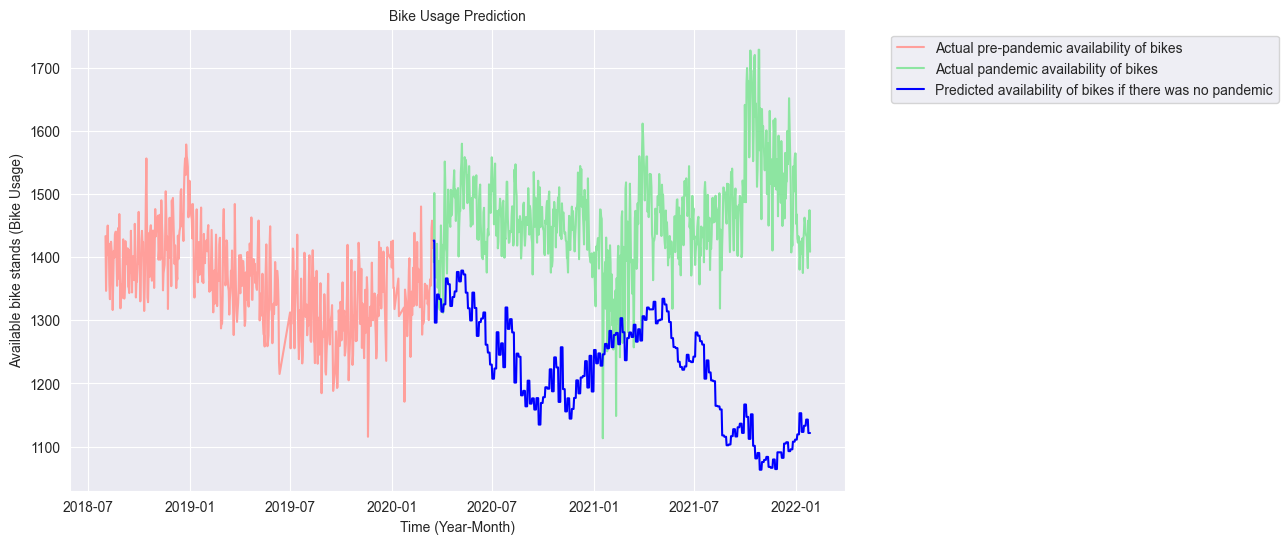

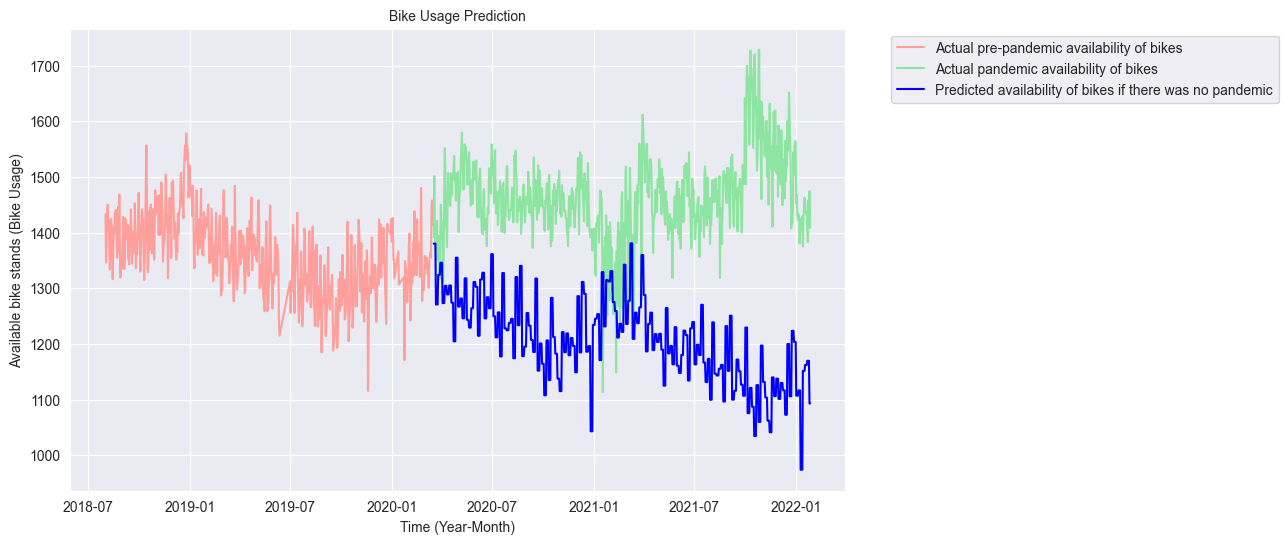

/var/folders/hw/ytmm6dq166j5v4hv7qq_zg3h0000gn/T/ipykernel_1072/3792443938.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predicted_usage = pd.concat([predicted_usage, bike_stands])
/var/folders/hw/ytmm6dq166j5v4hv7qq_zg3h0000gn/T/ipykernel_1072/3792443938.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predicted_dates = pd.concat([predicted_dates, time_data.apply(increment_year)])


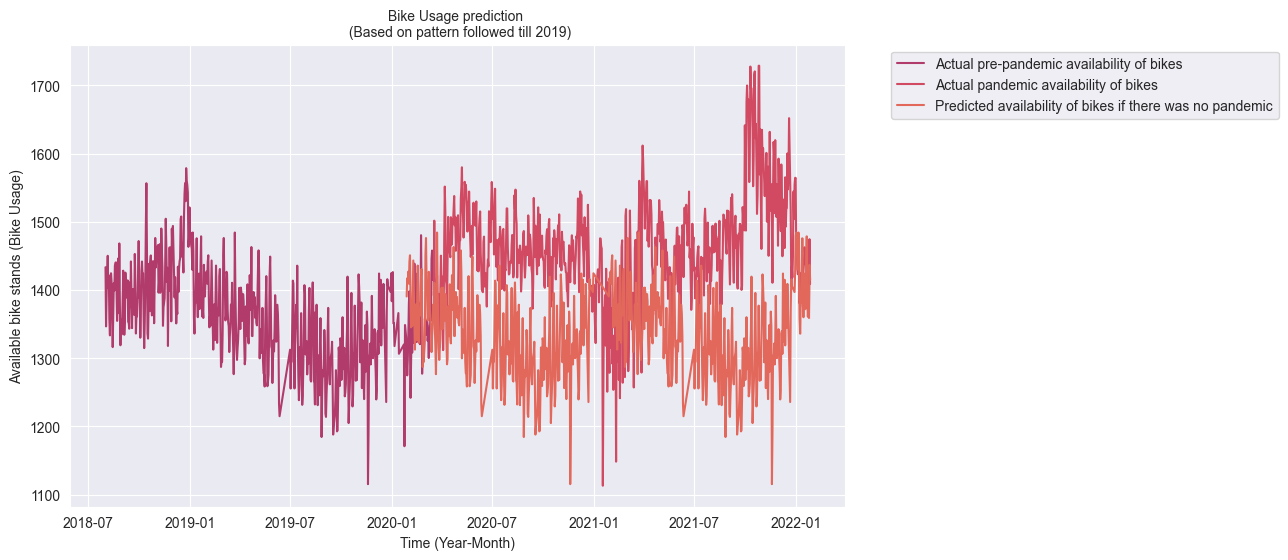

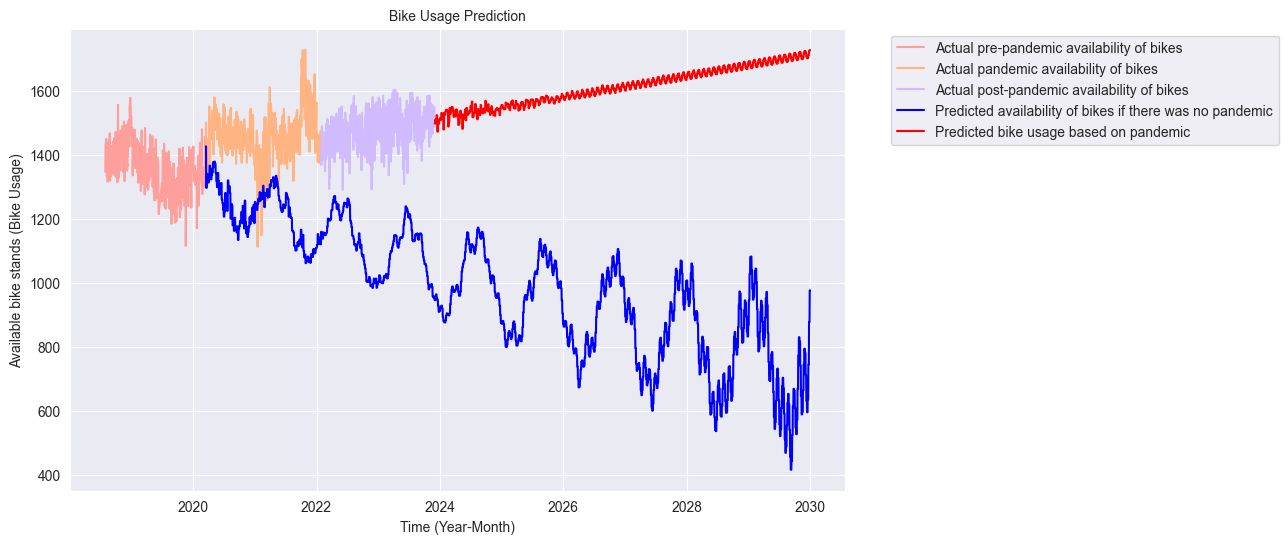

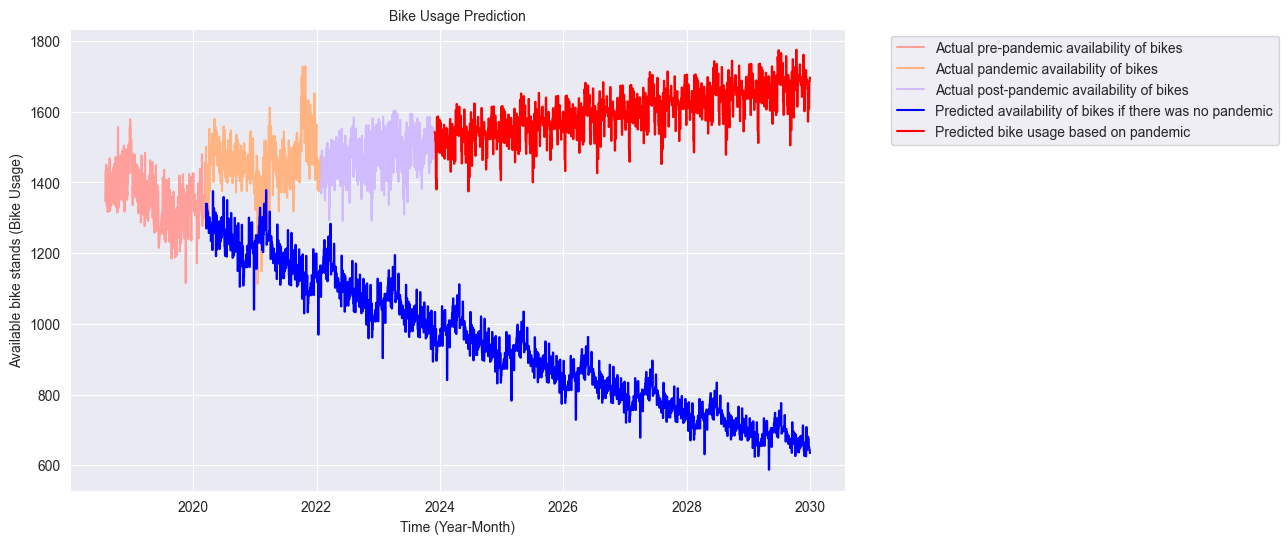

/var/folders/hw/ytmm6dq166j5v4hv7qq_zg3h0000gn/T/ipykernel_1072/3792443938.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predicted_usage = pd.concat([predicted_usage, bike_stands])
/var/folders/hw/ytmm6dq166j5v4hv7qq_zg3h0000gn/T/ipykernel_1072/3792443938.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predicted_dates = pd.concat([predicted_dates, time_data.apply(increment_year)])


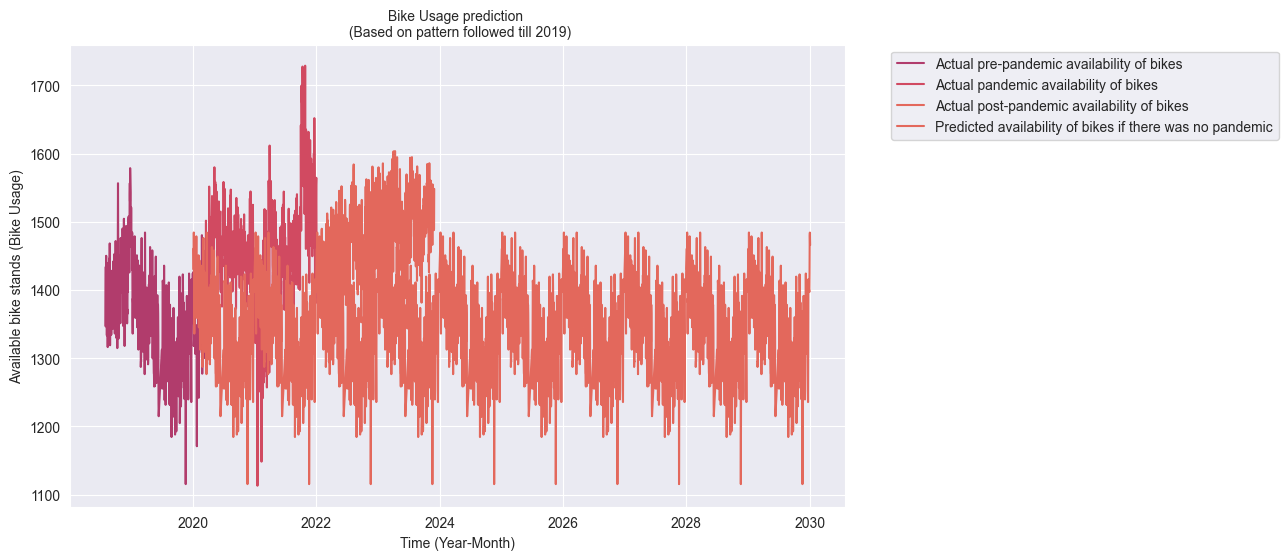

In [77]:
def main():
    # Load daily bike usage data
    pre_pandemic_data, pandemic_data, post_pandemic_data = load_daily_bike_usage_data()

    # Calculate the time interval between datapoints
    time_data = pd.array(pd.DatetimeIndex(pre_pandemic_data.iloc[:,1]).astype(np.int64)) / 1e9
    time_interval = time_data[1] - time_data[0]

    # Predict bike usage during the pandemic period
    multi_step_prediction(train_data=pre_pandemic_data, test_data=pandemic_data, lag=12, time_interval=time_interval, regularization_strength=1/(1*0.001), trends=["short-term", "week", "month"], stride=4, plot_graph=True, calculate_error=False, model_post_pandemic=False)
    multi_step_prediction(train_data=pre_pandemic_data, test_data=pandemic_data, lag=1, time_interval=time_interval, regularization_strength=1/(1*0.001), trends=["short-term", "week", "month", "half-year"], stride=4, plot_graph=True, calculate_error=False, model_post_pandemic=False)

    predict_bike_usage(pre_pandemic_data=pre_pandemic_data, pandemic_data=pandemic_data, post_pandemic_data=None, include_post_pandemic= False, prediction_end_date=pandemic_data['TIME'].iloc[-1])

    # Predict bike usage during the post-pandemic period
    combined_data = pd.concat([pandemic_data, post_pandemic_data])
    multi_step_prediction(train_data=pre_pandemic_data, test_data=combined_data, lag=12, time_interval=time_interval, regularization_strength=1/(2*0.001), trends=["short-term", "week", "month"], stride=4, plot_graph=True, calculate_error=False, model_post_pandemic=True)
    multi_step_prediction(train_data=pre_pandemic_data, test_data=combined_data, lag=1, time_interval=time_interval, regularization_strength=1/(2*0.001), trends=["short-term", "week", "month", "half-year"], stride=3, plot_graph=True, calculate_error=False, model_post_pandemic=True)
    
    predict_bike_usage(pre_pandemic_data=pre_pandemic_data, pandemic_data=pandemic_data, post_pandemic_data=post_pandemic_data, include_post_pandemic=True, prediction_end_date='2030-01-01')
    
if __name__ == "__main__":
    main()